# Exploratory Analysis of a Univariate Time Series

In this notebook, we'll delve deeply into a single univariate time series dataset, specifically `m4_monthly_dataset_43531.csv` from the M4 Time Series modeling competition. Our goal is to thoroughly understand its characteristics and underlying patterns.

We will look at the following -- 

- **Raw Data Visualization:** Display the plain raw time series to visually assess trends, cycles, and irregularities.

**Summarization**

- **Descriptive Statistics:** Examine central tendency and variability to sense the general behavior.
- **Rolling Statistics:** Analyze statistics on a rolling window basis to understand temporal changes more clearly.

**Correlation Plots**

- **Lag Plots:** Explore how observations at different lags relate to each other.
- **Autocorrelation and Partial Autocorrelation (ACF and PACF):** These plots reveal the extent of dependence on previous observations, crucial for selecting parameters in statistical forecasting models.

**Other tools**

- **Stationarity Test:** Determine if the time series has consistent statistical properties over time, a prerequisite for many models. If non-stationary, apply differencing to stabilize.

- **Time Series Decomposition:** Break down the series into trend, seasonality, and residuals. The trend shows long-term progression, seasonality indicates cyclical patterns, and residuals should ideally be stationary, further modeled to account for non-linear dependencies.

- **Fourier Decomposition:** Analyze the spectrum of frequencies to understand the impact of various cycles on the time series. For instance, prominent lower frequencies suggest significant short-term fluctuations.


By the end of this section, you will have a comprehensive understanding of how to systematically analyze a univariate time series. 

## Setup

In [2]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import json

import utils_tfb # contains the function to read/preprocess the datasets as provided by the authors

TS_DATA_FOLDER = pathlib.Path("./forecasting").resolve() # Data folder

random.seed(14)

In [6]:
dataset_name = "m4_monthly_dataset_43531.csv"
dataset = TS_DATA_FOLDER / dataset_name
data = utils_tfb.read_data(dataset)
data.head()

,channel_1
date,
1998-12-31 12:00:00,4155.7457
1999-01-31 12:00:00,4291.8389
1999-02-28 12:00:00,4168.7291
1999-03-31 12:00:00,4470.3329
1999-04-30 12:00:00,4710.2099


**Note:** The dataset processed by the authors contains a single column named `channel_1`, which follows the convention for univariate datasets in this series. This column represents the time series data we will analyze. In subsequent notebooks, we will explore multivariate datasets. Additionally, the dataset uses a DateTimeIndex for the indices, facilitating time-based operations and analysis.


In [7]:
data.index

DatetimeIndex(['1998-12-31 12:00:00', '1999-01-31 12:00:00',
               '1999-02-28 12:00:00', '1999-03-31 12:00:00',
               '1999-04-30 12:00:00', '1999-05-31 12:00:00',
               '1999-06-30 12:00:00', '1999-07-31 12:00:00',
               '1999-08-31 12:00:00', '1999-09-30 12:00:00',
               ...
               '2014-09-30 12:00:00', '2014-10-31 12:00:00',
               '2014-11-30 12:00:00', '2014-12-31 12:00:00',
               '2015-01-31 12:00:00', '2015-02-28 12:00:00',
               '2015-03-31 12:00:00', '2015-04-30 12:00:00',
               '2015-05-31 12:00:00', '2015-06-30 12:00:00'],
              dtype='datetime64[ns]', name='date', length=199, freq=None)

## Raw Time Series

<Axes: xlabel='date'>

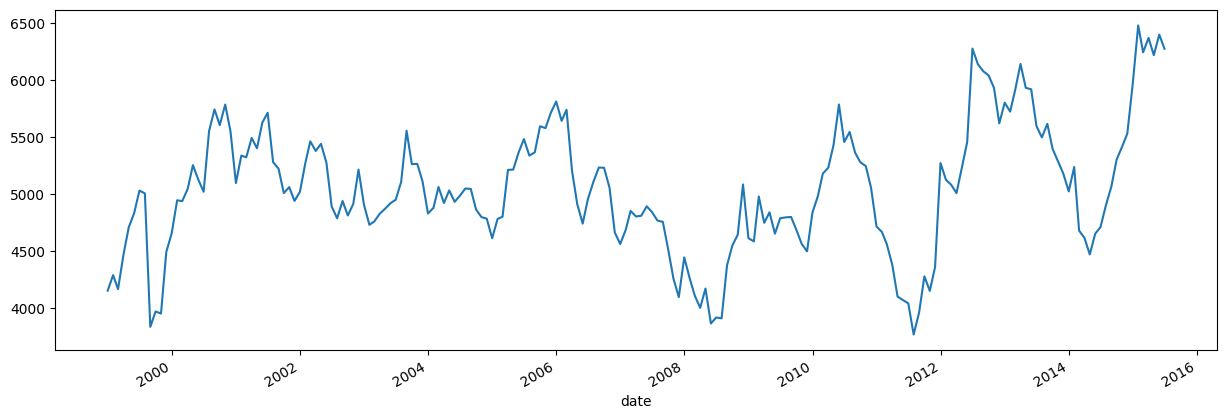

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5), dpi=100)
data['channel_1'].plot(ax=ax)

**Observations:**
1. There is evident periodicity within the data, suggesting that certain lags will demonstrate strong correlations due to recurring seasonal patterns.
2. The data exhibits considerable short-term fluctuations, indicating a likely presence of high-intensity low-frequency components in the power spectrum, reflecting these frequent changes.


## Summarization: Descriptive Statistics

In [9]:
data['channel_1'].describe()

count     199.000000
mean     5040.988221
std       558.636601
min      3771.425400
25%      4715.146550
50%      5021.611200
75%      5373.677050
max      6479.082900
Name: channel_1, dtype: float64

## Summarization: Rolling Statistics (Window=7)

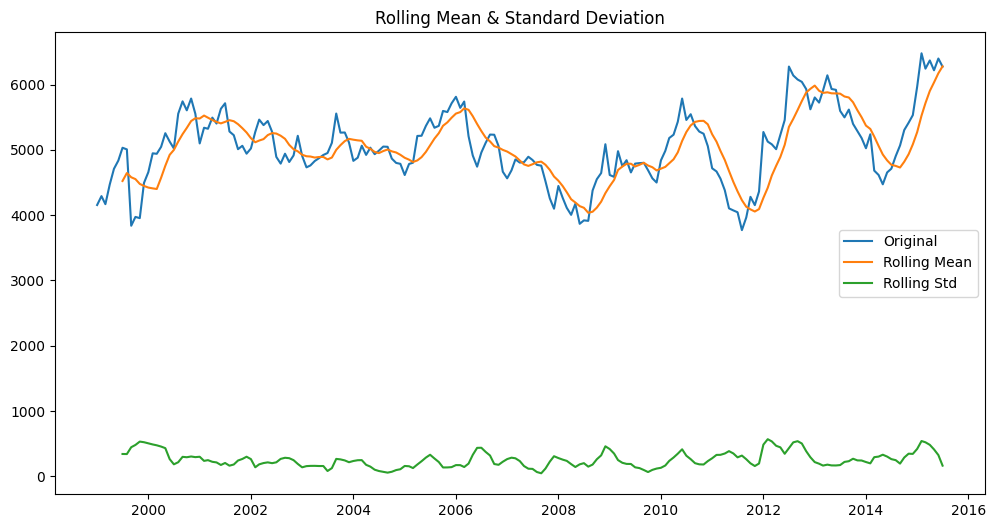

In [11]:
# Rolling statistics
rolling_mean = data['channel_1'].rolling(window=7).mean()
rolling_std = data['channel_1'].rolling(window=7).std()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['channel_1'], label='Original')
plt.plot(data.index, rolling_mean, label='Rolling Mean')
plt.plot(data.index, rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()


**Observations:** The time series exhibits varying temporal mean, suggesting that it may not be stationary. 

## Correlation Plots: Lag Plot

Text(0.5, 0.98, 'Lag Plot')

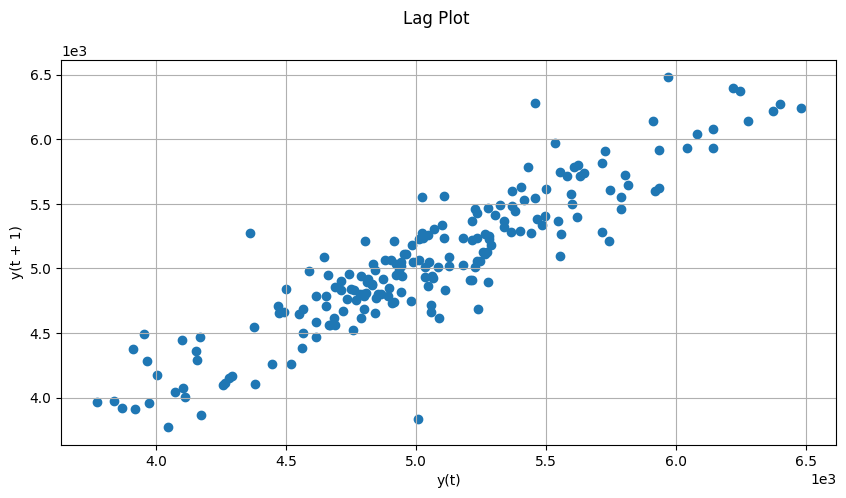

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

lags = np.arange(1, 15)
pd.plotting.lag_plot(data['channel_1'], ax=ax)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.grid()

fig.suptitle("Lag Plot")

## Correlation Plots: Autocorrelation

<StemContainer object of 3 artists>

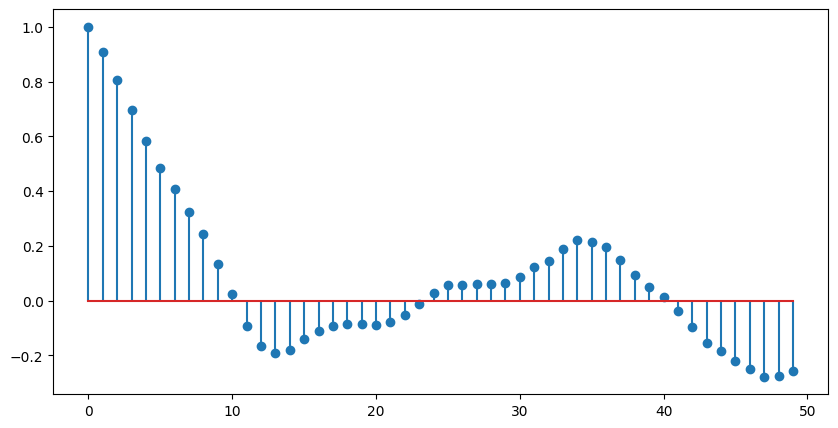

In [16]:
lags = np.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)
autocorrs = [data['channel_1'].autocorr(lag=lag) for lag in lags]
ax.stem(lags, autocorrs)

## Correlation Plots: Partial Autocorrelation

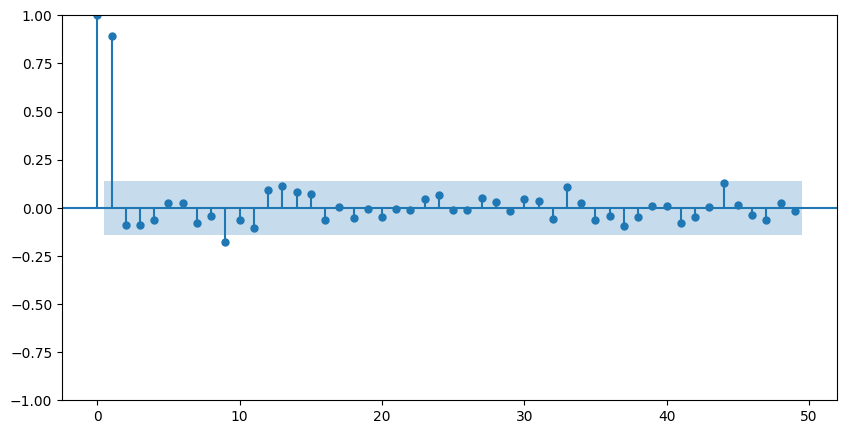

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

lags = np.arange(50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)
_ = plot_pacf(data['channel_1'], method='ywm', lags=lags, ax=ax, title=None)

**Note:**

- A sharp decline in autocorrelation at a lag suggests a strong correlation with the immediate previous value (t-1) and diminishing correlations with further lags. This characteristic is crucial for determining the autoregressive (AR) order in statistical models like ARIMA.

- Partial autocorrelation accounts for intermediate values, often showing more lower values than autocorrelation. This damping effect in PACF plots indicates that correlations observed in ACF may stem from these intermediate dependencies.

## Stationarity

In [18]:
# check stationarity 
from statsmodels.tsa.stattools import adfuller


alpha = 0.05
results = adfuller(data['channel_1'].values)
pvalue = results[1]

if pvalue < alpha:
    print(f"p-value: {pvalue: 0.5f}. Reject the null. The time series is stationary")
else:
    print(f"p-value: {pvalue: 0.5f}. Accept the null. The time series is non-stationary")



p-value:  0.10914. Accept the null. The time series is non-stationary


**Note:** As expected from the above plots, the time series is non-stationary. Consequently, to prepare for effective modeling, we should consider applying transformations like differencing that help induce stationarity.

## Time Series Decomposition

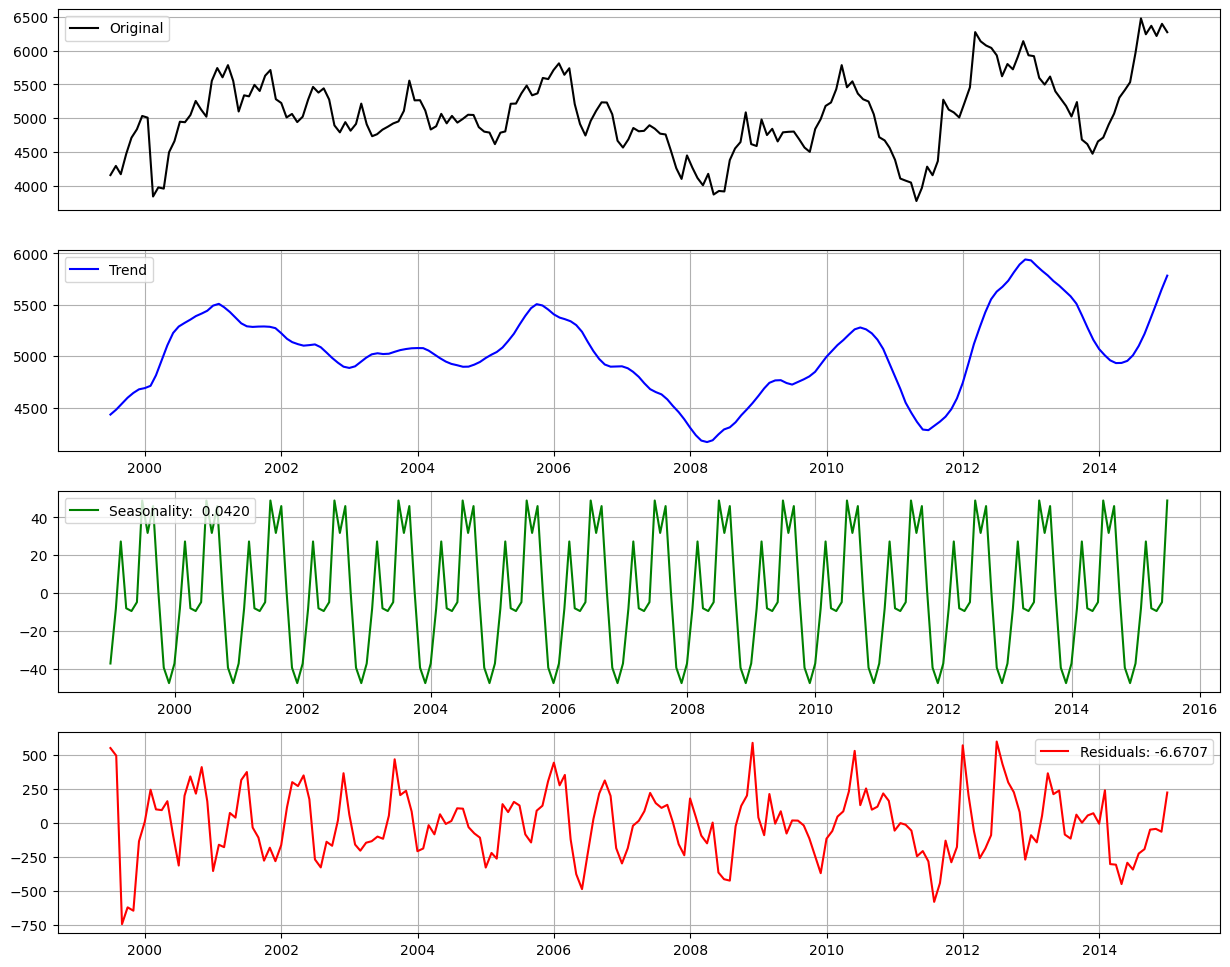

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 12), dpi=100)

# original series
ax = axs[0]
ax.plot(data.channel_1, color='black', label='Original')
ax.legend()
ax.grid()
ax.set_xticks([])

result = seasonal_decompose(data.channel_1, model="additive")

# trend
ax = axs[1]
ax.plot(result.trend, color='blue', label='Trend')
ax.legend()
ax.grid()

# seasonality
ax = axs[2]
ax.plot(result.seasonal, color="green", label=f'Seasonality: {result.seasonal.mean(): 0.4f}')
ax.legend()
ax.grid()

# residual
ax = axs[3]
ax.plot(result.resid, color="red", label=f'Residuals: {result.resid.mean(): 0.4f}')
ax.legend()
ax.grid()


**Note:** As expected, we observe a strong seasonality component in the time series. 

## Frequency Analysis

<StemContainer object of 3 artists>

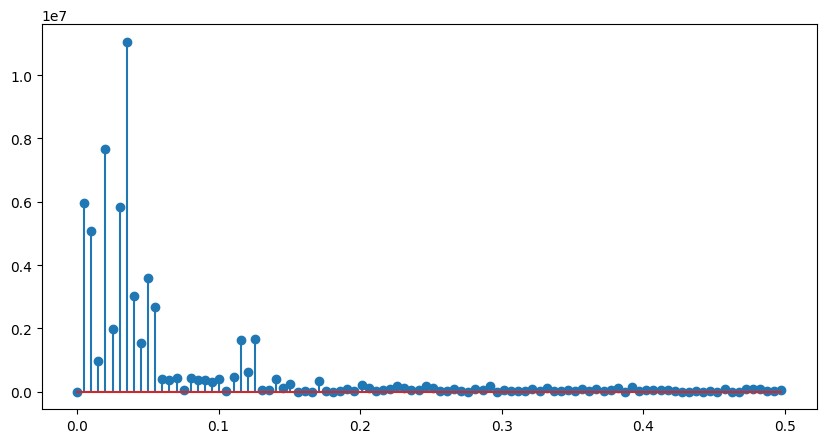

In [36]:
from scipy.signal import periodogram

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)
freqs, power = periodogram(data.channel_1.values)
ax.stem(freqs, power)

**Observation:** A high intensity of lower frequencies in the spectrum indicates rapid fluctuations in the time series.

## Next Steps

1. **Further Data Analysis (Optional):** Proceed to `01.2_datasets-multivariate-eda.ipynb` to analyze a specific multivariate dataset, applying more visualization tools to develop understanding of mutlivariate time series.

2. **Explore Advanced Tools:** Proceed to `01.4_gluonts_datasets.ipynb` to explore the GluonTS library, a powerful tool for developing advanced forecasting methods.

